# KNN Users Similarity

## Idea

The task is to take into account the demographic data of the user when selecting movie recommendations. I decided to implement this in the following way:
1. Find "similar" users using their demographic data (profession, gender, age)
2. Predict ratings for those films that "similar" users rated above 3 and already from these predictions give recommendations for viewing.
this notebook solves 1 point of the idea using KNN algorithm

In [85]:
import pandas as pd

In [86]:
df = pd.read_csv("../data/raw/preprocessed.csv")

In [87]:
df.head()

,Unnamed: 0,user_id,age,sex,occupation
0,0,1,0.257576,1,0.269982
1,1,2,0.696970,0,0.303543
2,2,3,0.242424,1,0.347147
3,3,4,0.257576,1,0.269982
4,4,5,0.393939,0,0.303543


In [88]:
from scipy.sparse import csr_matrix
df_sparse_filtered=csr_matrix(df.values)

The k-Nearest Neighbors (k-NN) algorithm with cosine similarity is well-suited for assessing user similarity based on demographic data. Cosine similarity considers both the direction and sparsity of vectors. 

In [89]:
from sklearn.neighbors import NearestNeighbors

In [90]:
knn_alg = NearestNeighbors(metric='cosine', algorithm='brute')
knn_alg.fit(df_sparse_filtered)

NearestNeighbors(algorithm='brute', metric='cosine')

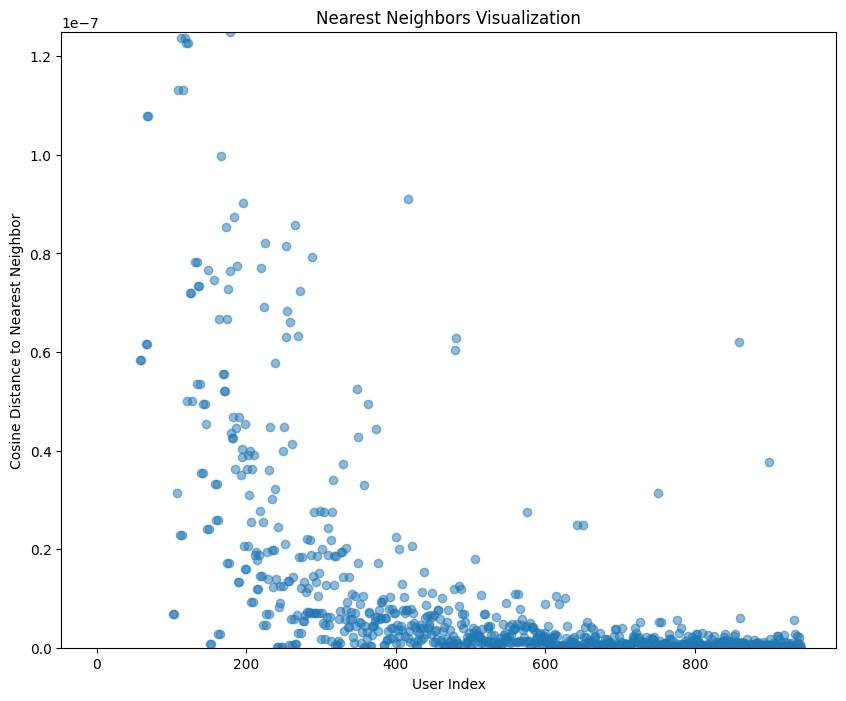

In [91]:
import matplotlib.pyplot as plt
distances, indices = knn_alg.kneighbors(df_sparse_filtered)

# Создаем график
plt.figure(figsize=(10, 8))
plt.scatter(range(len(distances)), distances[:, 1], alpha=0.5)
plt.title('Nearest Neighbors Visualization')
plt.xlabel('User Index')
plt.ylabel('Cosine Distance to Nearest Neighbor')
plt.ylim(0, 0.000000125)
plt.show()

The graph consists of points where each point represents a user (User Index), and the y coordinate of this point corresponds to the cosine distance to its nearest neighbor.

The point is near zero on the y axis, which indicates close neighbors for most users in the context of the selected cosine metric.

## Predicting similar users


In [92]:
import numpy as np

def get_similar_users(user, n = 5):

  knn_input = np.asarray([df.values[user-1]])
  distances, indices = knn_alg.kneighbors(knn_input, n_neighbors=n+1)
  
  print("Top",n,"users who are very much similar to the User-",user, "are: ")
  print(" ")
  for i in range(1,len(distances[0])):
    print(i,". User:", indices[0][i]+1, "separated by distance of",distances[0][i])
  return indices.flatten()[1:] + 1, distances.flatten()[1:]


In [93]:
from pprint import pprint
user_id = 778
similar_users_list,_ = get_similar_users(user_id, 10)
similar_users_list = [user_id] + similar_users_list.tolist()


Top 10 users who are very much similar to the User- 778 are: 
 
1 . User: 765 separated by distance of 8.171739951379209e-10
2 . User: 779 separated by distance of 8.731378953186208e-10
3 . User: 774 separated by distance of 1.44664002998951e-09
4 . User: 742 separated by distance of 1.9907303583366343e-09
5 . User: 770 separated by distance of 3.240693491335378e-09
6 . User: 758 separated by distance of 4.409118847803484e-09
7 . User: 757 separated by distance of 5.779428380314755e-09
8 . User: 771 separated by distance of 5.868000974018628e-09
9 . User: 847 separated by distance of 8.503022397299276e-09
10 . User: 727 separated by distance of 8.73939154377723e-09


To test the algorithm, we will output a list of all users who are "similar" to 778,

In [94]:
user_df = pd.read_csv("../data/raw/users.csv", index_col=0)
filtered_user_df = user_df[user_df['user_id'].isin(similar_users_list)]

In [95]:
filtered_user_df

,user_id,age,sex,occupation
726,727,25,M,student
741,742,35,M,student
756,757,26,M,student
757,758,27,M,student
764,765,31,M,student
769,770,28,M,student
770,771,26,M,student
773,774,30,M,student
777,778,34,M,student
778,779,31,M,student


Our user 778 is a 34 year old male student
"Similar" users are 25-35 year old male students
The demographic data is really similar, which means that the algorithm works correctly.

## Saving model

Let's save our model for later use in point 2 of the idea.

In [96]:
import pickle

In [97]:
with open('../models/similar_users_model.pkl', 'wb') as model_file:
    pickle.dump(knn_alg, model_file)